# Show and Tell - attention based model
## Trained - now reload weights and do inference

### Based on link: https://www.tensorflow.org/tutorials/text/image_captioning

### The model architecture is similar to Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.
#### Arch paper: https://arxiv.org/abs/1502.03044

# Trained model already and saved weights.
# Now reload to do inference

## First phase of training already done and pickled various files to resume training with the data being split in a deterministic manner.

## Will not do all the steps again and simply load all the info from the pickled files:
## Descriptions, image_encodings, embedding_matrix, etc.

### The encoder is pre-trained Google Inception-v3 trained on Imagenet.

## AVAILABLE data :
### Coco_Train2017     = has 118287 images
### Coco_Val2017       = has 5000   images
### Combined total     = 123287     images

## USED data :
### Coco_Train2017     = 100000  images
### Coco_Val2017       = 5000    images
### Combined total     = 105000  images

### Using only the first 100k images of Train2017 + all 5k images of Val2017
### Thus total data available for training = 100k + 5k = 105k
### Details of split of data:
### Training   data = 97000 images from Coco_Train2017
### Validation data = 3000  images from Coco_Train2017
### Test       data = 5000  images from Coco_Val2017

### Note: 1) Each image will have multiple captions (up to 5 as some may be discarded)
###       2) Not using the Coco_Test2017 dataset at all as it has no annotations json file which has the captions.

In [48]:
import os
import sys
import json
import time
import datetime
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import re
import pickle
from glob import glob
import collections
import random
import PIL

from IPython.display import display as ipy_display

In [41]:
## Local versions

## to make deterministic
IPDIR_DETERMINISTIC_ATTEND = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_Deterministic_Run4/'

## new images - unseen during testing - part of Coco 2017 Test dataset
TEST_IMGS_DIR = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/'

# Model
### Fun fact: the decoder below is identical to the one in the example for Neural Machine Translation with Attention (https://www.tensorflow.org/tutorials/sequences/nmt_with_attention).

### The model architecture is inspired by the Show, Attend and Tell paper (https://arxiv.org/pdf/1502.03044.pdf).

### In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
### You squash that to a shape of (64, 2048).
### This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
### The RNN (here GRU) attends over the image to predict the next word.

In [4]:
embedding_dim = 256
units = 512
top_k = 5000
vocab_size = top_k + 1
max_length = 52
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [5]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [6]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [7]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [8]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [11]:
optimizer = tf.keras.optimizers.Adam()

# Checkpoint

In [12]:
CHKPT_DIR

'/home/rohit/PyWDUbuntu/thesis/ImgCapATTEND_opdir_DUMMY_RUN/chkPointDir_DUMMY_RUN/train_DUMMY_RUN/'

In [13]:
os.listdir(CHKPT_DIR)

['ckpt-18.index',
 'checkpoint',
 'ckpt-15.data-00000-of-00001',
 'ckpt-19.data-00000-of-00001',
 'ckpt-17.index',
 'ckpt-19.index',
 'ckpt-16.data-00000-of-00001',
 'ckpt-16.index',
 'ckpt-15.index',
 'ckpt-17.data-00000-of-00001',
 'ckpt-18.data-00000-of-00001']

In [14]:
checkpoint_path = CHKPT_DIR
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [25]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

start_epoch

19

In [27]:
decoder.summary()

Model: "rnn__decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1280256   
_________________________________________________________________
gru (GRU)                    multiple                  1575936   
_________________________________________________________________
dense_1 (Dense)              multiple                  262656    
_________________________________________________________________
dense_2 (Dense)              multiple                  2565513   
_________________________________________________________________
bahdanau_attention (Bahdanau multiple                  394753    
Total params: 6,079,114
Trainable params: 6,079,114
Non-trainable params: 0
_________________________________________________________________


In [28]:
decoder.attention.summary()

Model: "bahdanau_attention"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  131584    
_________________________________________________________________
dense_4 (Dense)              multiple                  262656    
_________________________________________________________________
dense_5 (Dense)              multiple                  513       
Total params: 394,753
Trainable params: 394,753
Non-trainable params: 0
_________________________________________________________________


# Reload Tokenizer reload the correct one used during full training run

In [29]:
IPDIR_DETERMINISTIC_ATTEND

'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_Deterministic_Run4/'

In [30]:
os.listdir(IPDIR_DETERMINISTIC_ATTEND)

['ATTEND_images_run4_5k_for_bleu_scoring.pkl',
 'tokenizer_run4_from_training_100k.pkl']

In [31]:
## Reload all the files to make it deterministic

# variable = tokenizer
with open(IPDIR_DETERMINISTIC_ATTEND + 'tokenizer_run4_from_training_100k.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

print(f"Reload success")

print(f"{type(tokenizer)}")

Reload success
<class 'keras_preprocessing.text.Tokenizer'>


In [ ]:
IPDIR_WEIGHTS_IN

In [ ]:
os.listdir(IPDIR_WEIGHTS_IN)

In [ ]:
wts_file_to_reload = r'ATTEND_Run4_Decoder_wts_ep_0.h5'

In [ ]:
WEIGHTS_FILE_RELOAD = IPDIR_WEIGHTS_IN + wts_file_to_reload
WEIGHTS_FILE_RELOAD

In [ ]:
os.path.exists(WEIGHTS_FILE_RELOAD)

In [ ]:
decoder.load_weights(WEIGHTS_FILE_RELOAD)
print(f"Success reloading weights")

# Setup encoder related stuff

In [32]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [33]:
## Initialize InceptionV3 and load the pretrained Imagenet weights
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
type(image_model)

tensorflow.python.keras.engine.functional.Functional

# Caption

### The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
### Stop predicting when the model predicts the end token.
### And store the attention weights for every time step.

In [36]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    #attention_plot = attention_plot[:len(result), :]
    attention_plot = None
    return result, attention_plot

In [37]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [38]:
new_image = r'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000016.jpg'

Model predicted caption =
['a', 'photo', 'of', 'a', 'hitter', 'and', 'helmet', 'awaiting', 'a', 'pitch', 'during', 'a', 'baseball', 'game', '<end>']


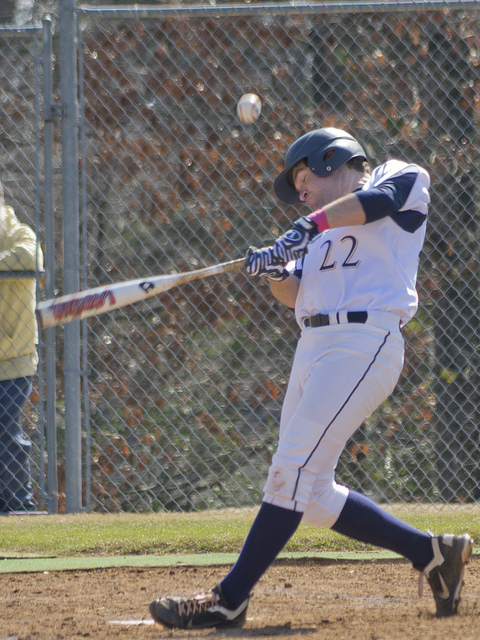

In [39]:
## after the ckpt.restore
image = new_image
#real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print(f"Model predicted caption =\n{result}")
PIL.Image.open(new_image)

In [43]:
few_test_imgs = os.listdir(TEST_IMGS_DIR)[:10]
few_test_imgs

['000000000001.jpg',
 '000000000016.jpg',
 '000000000019.jpg',
 '000000000057.jpg',
 '000000000063.jpg',
 '000000000069.jpg',
 '000000000080.jpg',
 '000000000090.jpg',
 '000000000106.jpg',
 '000000000108.jpg']

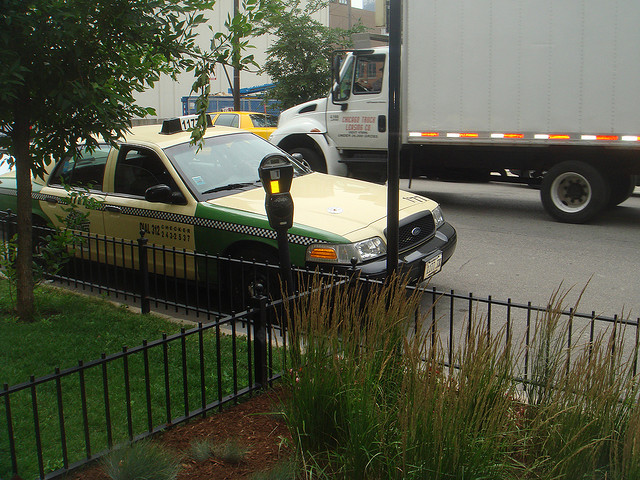

Input image = /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000001.jpg

Predicted caption =
a bus parked at a car


--------------------
--------------------



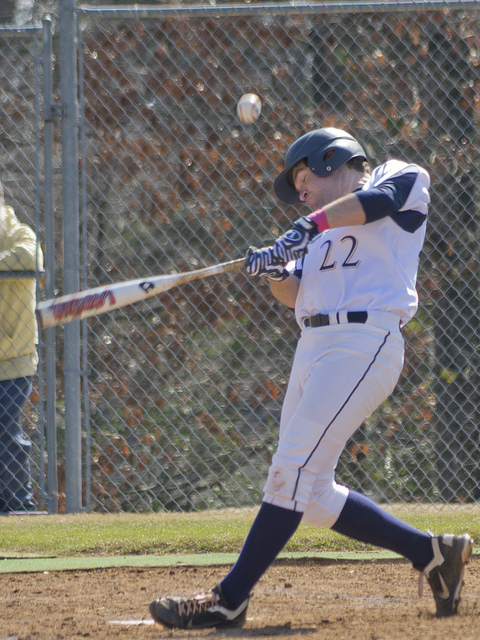

Input image = /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000016.jpg

Predicted caption =
a baseball player with an intense baseball bat as another men standing next pitch


--------------------
--------------------



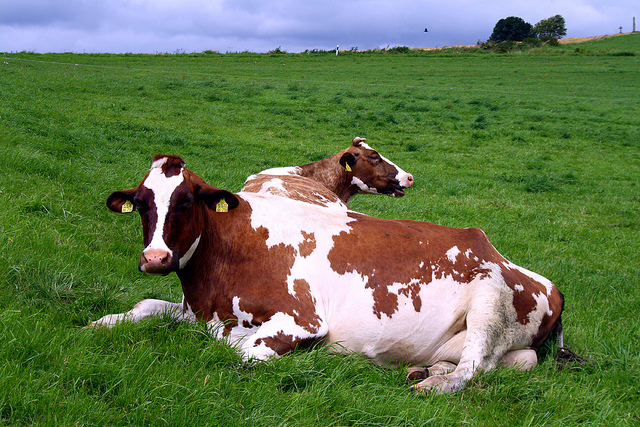

Input image = /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000019.jpg

Predicted caption =
a woman poses on top of a wide farm


--------------------
--------------------



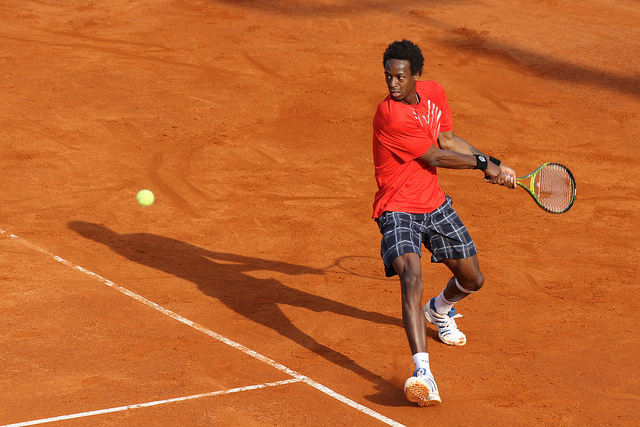

Input image = /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000057.jpg

Predicted caption =
a man holding a tennis racket on a tennis court


--------------------
--------------------



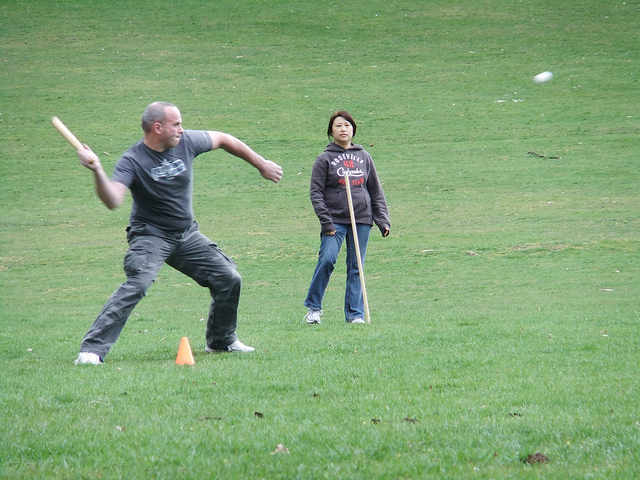

Input image = /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000063.jpg

Predicted caption =
one swinging a neon green shoes on his hip


--------------------
--------------------



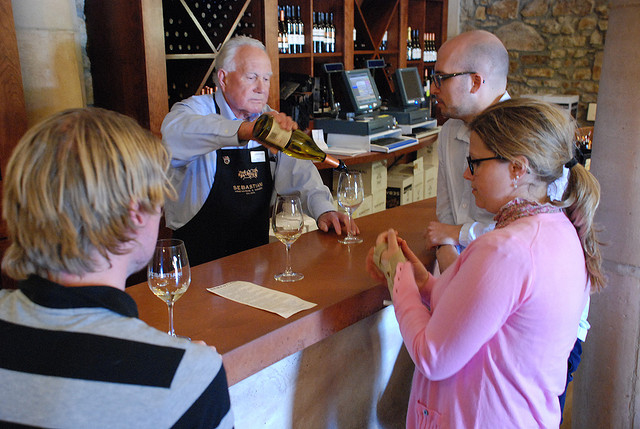

Input image = /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000069.jpg

Predicted caption =
a woman and a man and one child feeding each other's company


--------------------
--------------------



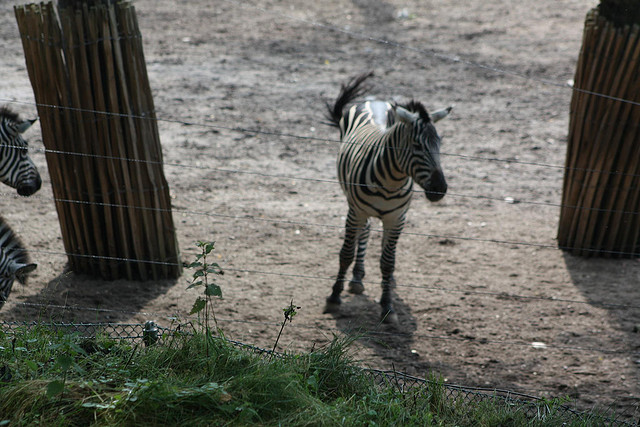

Input image = /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000080.jpg

Predicted caption =
a zebra bends forward towards different <unk> glass


--------------------
--------------------



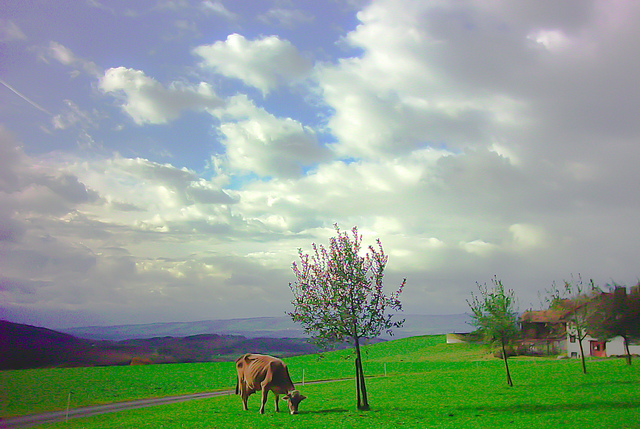

Input image = /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000090.jpg

Predicted caption =
a horse walks around a field near an open green area of water


--------------------
--------------------



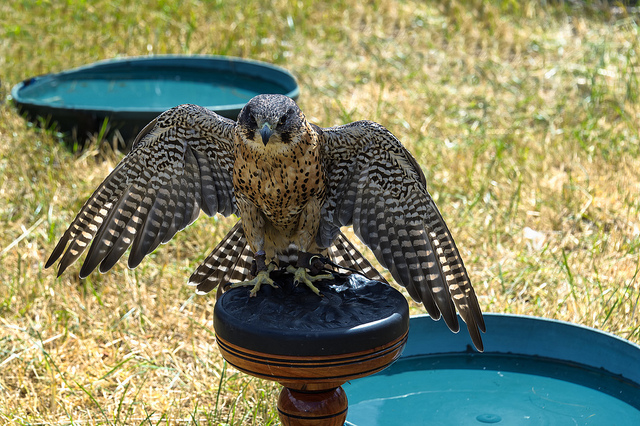

Input image = /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000106.jpg

Predicted caption =
three black birds perched on a grassy field


--------------------
--------------------



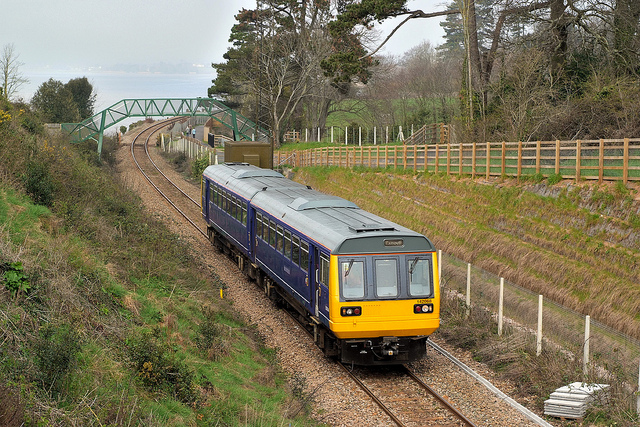

Input image = /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000108.jpg

Predicted caption =
a passenger train passing over the tracks in it's center


--------------------
--------------------



In [53]:
for i, new_img in enumerate(few_test_imgs):
    img_to_pred = TEST_IMGS_DIR + new_img
    
    ipy_display(PIL.Image.open(img_to_pred))
    #PIL.Image.open(img_to_pred)
    result, attention_plot = evaluate(img_to_pred)
    if result[-1] == '<end>':
        result = result[:-1]
    result = ' '.join(result[:])
    print(f"Input image = {img_to_pred}\n")
    print(f"Predicted caption =\n{result}\n")
    
    print(f"\n{'-'*20}\n{'-'*20}\n")